In [1]:
import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Utils.ModelWrapper import ModelWrapper
from Modules.Models.BuildBINNs import BINN

import Modules.Loaders.DataFormatter as DF

In [2]:
device = torch.device(GetLowestGPU(pick_from=[2]))

Device set to cuda:2


In [ ]:
path = '../Data/'
file_name = 'cell_density_profiles.npy'
densities = ['dens_10000', 'dens_12000', 'dens_14000', 
             'dens_16000', 'dens_18000', 'dens_20000']
density_idx = 5 # 0, ..., 5
density = densities[density_idx]
gamma = 0.2

inputs, outputs, shape = DF.load_cell_migration_data(path+file_name, density_idx, plot=True)

data shapes (100, 120) (100, 120) (100, 120)
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.60606061  0.60606061  0.60606061 ...  0.60606061  0.60606061
   0.60606061]
 [ 1.21212121  1.21212121  1.21212121 ...  1.21212121  1.21212121
   1.21212121]
 ...
 [58.78787879 58.78787879 58.78787879 ... 58.78787879 58.78787879
  58.78787879]
 [59.39393939 59.39393939 59.39393939 ... 59.39393939 59.39393939
  59.39393939]
 [60.         60.         60.         ... 60.         60.
  60.        ]]
[[0.29666667 0.30366667 0.2975     ... 0.29483333 0.28466667 0.30533333]
 [0.3258205  0.32584617 0.32433333 ... 0.305      0.31483333 0.323     ]
 [0.34233333 0.33766667 0.33651373 ... 0.33066667 0.324      0.34166667]
 ...
 [0.41233333 0.39483333 0.40916667 ... 0.38566667 0.3965     0.

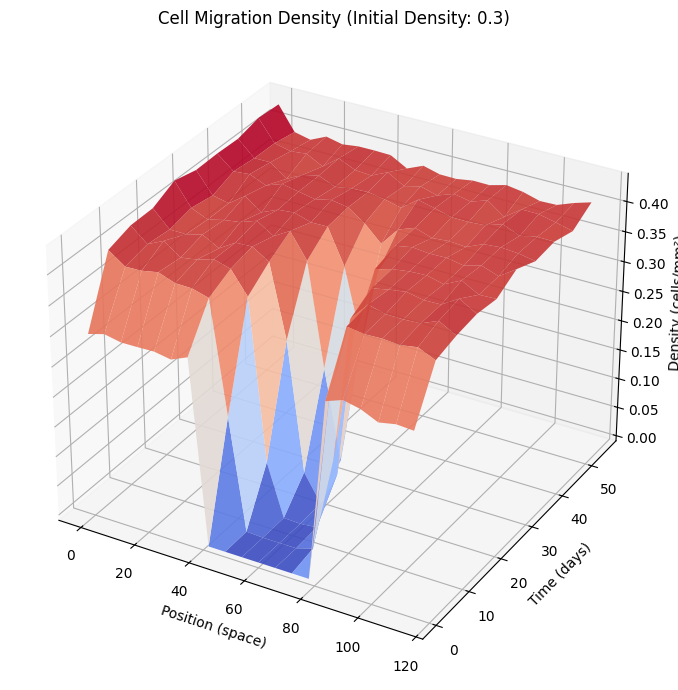

In [3]:
path = '../Data/Data/'
file_name = 'modified_logistic_ABM_BINNs_sim_2rp_0.5_rd_0.25_rm_1.0_scale_2_dens_0.3_complete.npy'
densities = [0.3]
density_idx = 0 # 0, ..., 5
density = densities[density_idx]
gamma = 0.2

inputs, outputs, shape = DF.load_cell_migration_data(path+file_name, density_idx, plot=True)

In [ ]:
#plots density as a function of time, step 1 to estimating a realiztic maximum value for growth
import numpy as np
import matplotlib.pyplot as plt

# Load data (example path and density key)
data = np.load(path+file_name, allow_pickle=True).item()
density_key = f'dens_0.3'
T = data[density_key]['T']   # shape (num_t, space_dim)
U = data[density_key]['U']   # shape (num_t, space_dim)

# Get time vector (same in all columns of T)
t_out = T[:, 0]

# Compute mean cell density across space for each time
avg_density = np.mean(U, axis=1)

# Plot average density vs time
plt.figure(figsize=(8, 5))
plt.plot(t_out, avg_density, color='darkgreen', linewidth=2, label='Average Density')
plt.xlabel('Time (non-dimensionalized)', fontsize=12)
plt.ylabel('Average Cell Density', fontsize=12)
plt.title('Cell Density vs Time', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

t = np.asarray(t_out).flatten()
y = np.asarray(avg_density).flatten()
n = len(t)
dydt = np.zeros(n)

# Forward difference for the first point
dydt[0] = (y[1] - y[0]) / (t[1] - t[0])

# Centered differences for internal points
for i in range(1, n - 1):
    dydt[i] = (y[i+1] - y[i-1]) / (t[i+1] - t[i-1])

# Backward difference for the last point
dydt[-1] = (y[-1] - y[-2]) / (t[-1] - t[-2])

# Plot average density change vs time
plt.figure(figsize=(8, 5))
plt.plot(t, dydt, color='darkgreen', linewidth=2, label='Average Density')
plt.xlabel('Time (non-dimensionalized)', fontsize=12)
plt.ylabel('Average Cell Density Change', fontsize=12)
plt.title('Cell Density Change vs Time', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
final = dydt/avg_density

# Plot average density change vs time
plt.figure(figsize=(8, 5))
plt.plot(avg_density, final, color='darkgreen', linewidth=2, label='Growth')
plt.xlabel('Average Density', fontsize=12)
plt.ylabel('Growth', fontsize=12)
plt.title('Growth vs Time', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Combine into a 2D array: columns are [relative_growth_rate, avg_density]
growth_vs_density = np.vstack((final, avg_density)).T  # shape (N, 2)

# Save as .npy
np.save("../Data/Data/growth_vs_density.npy", growth_vs_density)


In [4]:
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

# split into train/val and convert to torch
N = len(inputs)
split = int(0.8*N)
p = np.random.permutation(N)
print(inputs.shape)
x_train = to_torch(inputs[p[:split]])
y_train = to_torch(outputs[p[:split]])
x_val = to_torch(inputs[p[split:]])
y_val = to_torch(outputs[p[split:]])
inputs = to_torch(inputs)
outputs = to_torch(outputs)

(200, 2)


In [5]:
# initialize model
binn = BINN(delay=False)
binn.to(device)

# compile 
parameters = binn.parameters()
opt = torch.optim.Adam(parameters, lr=1e-3)
model = ModelWrapper(
    model=binn,
    optimizer=opt,
    loss=binn.loss,
    augmentation=None,
    save_name='../Weights/test')

In [6]:
epochs = int(1000)
batch_size = 37
rel_save_thresh = 0.05

import torch
import pandas as pd

class LossLoggerCallback:
    """
    Custom callback to store GLS, PDE, and constraint losses after each epoch.
    Compatible with custom ModelWrapper and BINN class.
    """
    def __init__(self):
        self.history = {
            'epoch': [],
            'gls_loss': [],
            'pde_loss': [],
            'constraint_loss': [],
            'total_loss': [],
        }

    def on_train_begin(self, wrapper): 
        pass
    def on_train_end(self, wrapper): 
        pass
    def on_epoch_begin(self, wrapper): 
        pass

    def on_epoch_end(self, wrapper):
        model = wrapper.model
        epoch_idx = len(self.history['epoch'])
    
        # Detach losses
        gls_loss = model.gls_loss_val.item() if hasattr(model, 'gls_loss_val') else 0.0
        pde_loss = model.pde_loss_log.item() if hasattr(model, 'pde_loss_log') else 0.0
    
        constraint_loss = 0.0
        for attr in ['D_loss', 'G_loss', 'T_loss']:
            if hasattr(model, attr):
                val = getattr(model, attr)
                if isinstance(val, torch.Tensor):
                    constraint_loss += val.detach().mean().item()
                else:
                    constraint_loss += val  # assume float
    
        total_loss = gls_loss + pde_loss + constraint_loss
    
        # Save as numbers, NOT tensors
        self.history['epoch'].append(epoch_idx)
        self.history['gls_loss'].append(gls_loss)
        self.history['pde_loss'].append(pde_loss)
        self.history['constraint_loss'].append(constraint_loss)
        self.history['total_loss'].append(total_loss)

    def on_batch_begin(self, wrapper): pass
    def on_batch_end(self, wrapper): pass

    def as_dataframe(self):
        return pd.DataFrame(self.history)

loss_logger = LossLoggerCallback()

# train jointly
model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,# initialize model
    epochs=epochs,
    callbacks= [loss_logger],
    verbose=1,
    validation_data=[x_val, y_val],
    early_stopping=5000,
    rel_save_thresh=rel_save_thresh)

Epoch 999 | Train loss = 1.2067e-02 | Val loss = 5.0212e-03 | Elapsed = 0:02:46             


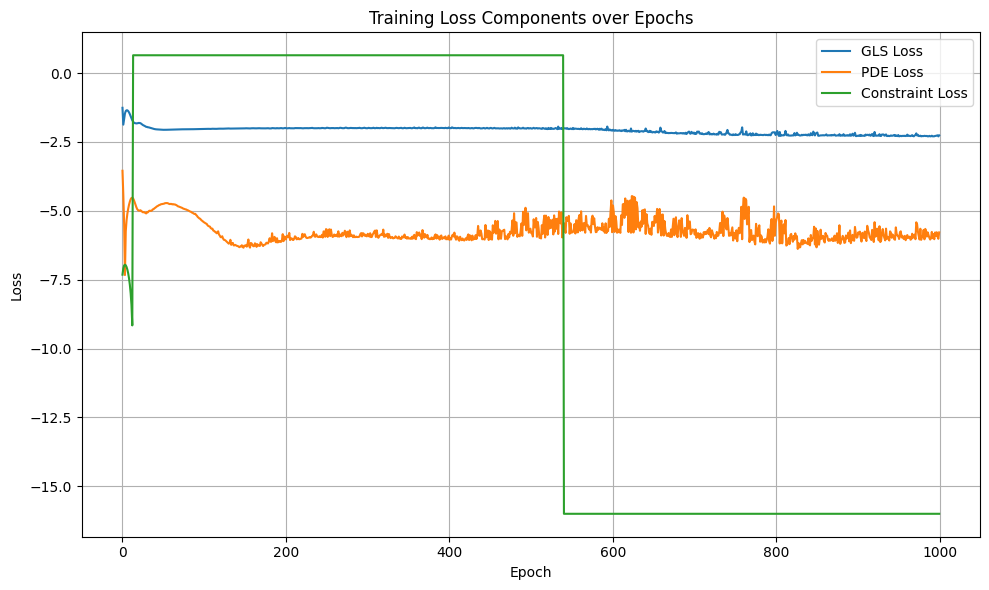

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your logger is named `loss_logger`
history_df = loss_logger.as_dataframe()

# Plot the three losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(history_df['epoch'], np.log10(history_df['gls_loss']), label='GLS Loss', color='tab:blue')
plt.plot(history_df['epoch'], np.log10(history_df['pde_loss']), label='PDE Loss', color='tab:orange')
plt.plot(history_df['epoch'], np.log10(history_df['constraint_loss']+1e-16), label='Constraint Loss', color='tab:green')

# Labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Perform prediction on validation/training set
pred = binn(x_train)

# Get individual loss components
losses = binn.evaluate_losses(pred, y_train)

# Print them nicely
print(f"\n🔍 Loss Breakdown:")
print(f"Total Loss:      {losses['total']:.6f}")
print(f"GLS Loss:        {losses['gls']:.6f}")
print(f"PDE Loss:        {losses['pde']:.6f}")
print(f"Constraint Loss: {losses['constraints']:.6f}")

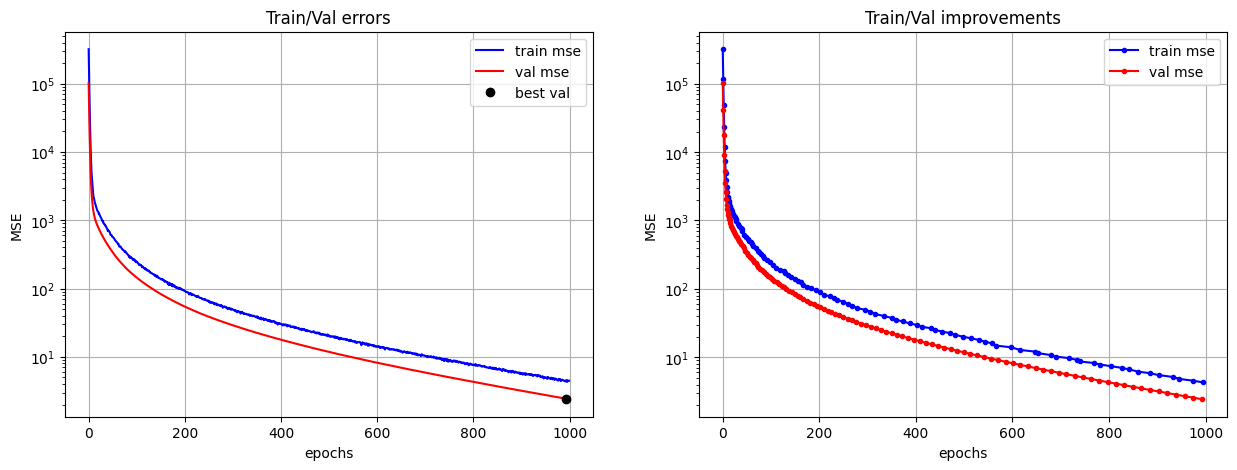

In [8]:
# load training errors
total_train_losses = model.train_loss_list
total_val_losses = model.val_loss_list

# find where errors decreased
train_idx, train_loss, val_idx, val_loss = [], [], [], []
best_train, best_val = 1e12, 1e12
for i in range(len(total_train_losses)-1):
    rel_diff = (best_train - total_train_losses[i])
    rel_diff /= best_train
    if rel_diff > rel_save_thresh:
        best_train = total_train_losses[i]
        train_idx.append(i)
        train_loss.append(best_train)
    rel_diff = (best_val - total_val_losses[i])
    rel_diff /= best_val
    if rel_diff > rel_save_thresh:
        best_val = total_val_losses[i]
        val_idx.append(i)
        val_loss.append(best_val)
idx = np.argmin(val_loss)

# plot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
plt.semilogy(total_train_losses, 'b')
plt.semilogy(total_val_losses, 'r')
plt.semilogy(val_idx[idx], val_loss[idx], 'ko')
plt.legend(['train mse', 'val mse', 'best val'])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train/Val errors')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
plt.semilogy(train_idx, train_loss, 'b.-')
plt.semilogy(val_idx, val_loss, 'r.-')
plt.legend(['train mse', 'val mse'])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train/Val improvements')
plt.grid()
plt.show()